Number of refer states: 2000
Number of actual states: 2000
Number of global path: 1460


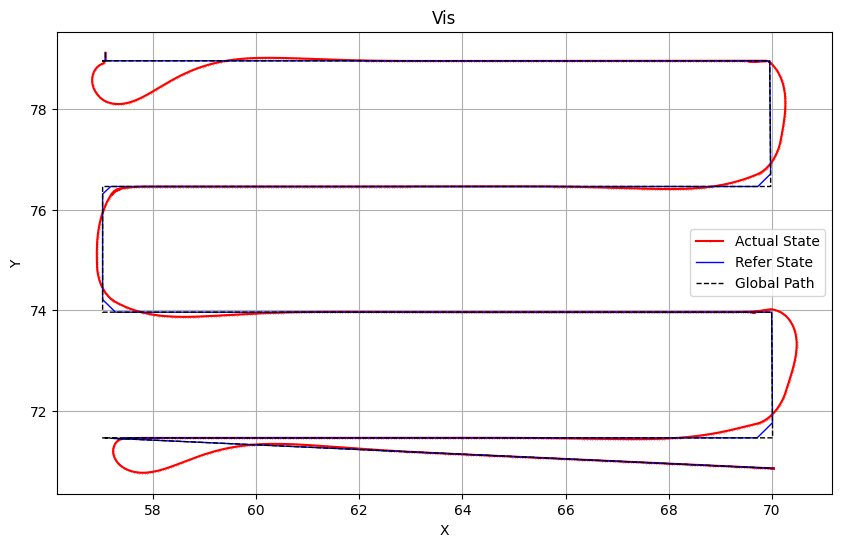

In [47]:
import matplotlib.pyplot as plt
from google.protobuf.json_format import MessageToDict
from generated.tracking_data_pb2 import TrackingData


def load_protobuf_data(file_path):
    tracking_data = TrackingData()
    with open(file_path, "rb") as f:
        tracking_data.ParseFromString(f.read())
    return tracking_data


def extract_trajectories(tracking_data):
    data_dict = MessageToDict(tracking_data)
    refer_states = data_dict.get("referState", [])
    actual_states = data_dict.get("actualState", [])
    global_path = data_dict.get("globalPoint", [])
    refer_x = [state["x"] for state in refer_states]
    refer_y = [state["y"] for state in refer_states]
    actual_x = [state["x"] for state in actual_states]
    actual_y = [state["y"] for state in actual_states]
    global_x = [state["x"] for state in global_path]
    global_y = [state["y"] for state in global_path]
    print(f"Number of refer states: {len(refer_states)}")
    print(f"Number of actual states: {len(actual_states)}")
    print(f"Number of global path: {len(global_x)}")
    return refer_x, refer_y, actual_x, actual_y, global_x, global_y


def plot_trajectories(refer_x, refer_y, actual_x, actual_y, global_x, global_y):
    plt.figure(figsize=(10, 6))
    plt.plot(
        actual_x,
        actual_y,
        label="Actual State",
        marker=".",
        markersize=0.5,
        color="red",
    )
    plt.plot(
        refer_x,
        refer_y,
        label="Refer State",
        linestyle="-",
        linewidth=1,
        color="blue",
    )
    plt.plot(
        global_x,
        global_y,
        label="Global Path",
        linestyle="--",
        linewidth=1,
        color="black",
    )
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Vis")
    plt.legend()
    plt.grid(True)
    plt.show()


def main():
    protobuf_file_path = (
        "/tmp/ros/proto/traj_tracking/tracking_data_1733986508.517617351"
    )
    tracking_data = load_protobuf_data(protobuf_file_path)
    refer_x, refer_y, actual_x, actual_y, global_x, global_y = extract_trajectories(
        tracking_data
    )
    plot_trajectories(refer_x, refer_y, actual_x, actual_y, global_x, global_y)


if __name__ == "__main__":
    main()

In [6]:
from generated.tracking_data_pb2 import TrackingData  # 替换为实际生成的 Protobuf 模块
import matplotlib.pyplot as plt

# 加载 Protobuf 数据
def load_protobuf_data(file_path):
    tracking_data = TrackingData()
    with open(file_path, 'rb') as f:
        tracking_data.ParseFromString(f.read())
    return tracking_data

# 提取 global_traj 数据
def extract_global_traj(tracking_data):
    global_path = tracking_data.global_path
    print(global_path)
    x_coords = list(global_path.x)  # 提取 x 坐标列表
    y_coords = list(global_path.y)  # 提取 y 坐标列表
    return x_coords, y_coords

# 绘制 global_traj
def plot_global_traj(x_coords, y_coords):
    plt.figure(figsize=(10, 6))
    plt.plot(x_coords, y_coords, label="Global Trajectory", marker='o')
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title("Global Trajectory Visualization")
    plt.legend()
    plt.grid(True)
    plt.show()

# 主函数
def main():
    protobuf_file_path = '/tmp/ros/proto/traj_tracking/tracking_data_1733974674.48721103'  # 替换为你的 Protobuf 文件路径
    tracking_data = load_protobuf_data(protobuf_file_path)
    x_coords, y_coords = extract_global_traj(tracking_data)
    plot_global_traj(x_coords, y_coords)

if __name__ == '__main__':
    main()


FileNotFoundError: [Errno 2] No such file or directory: '/tmp/ros/proto/traj_tracking/tracking_data_1733974674.48721103'